# Topic Detection and topic tracking using DistilBERT Model
Prepared by :

*   chaimaa bouabd
*   BENZAKRY Aimad


Supervised By :
*  

# Import data from kaggle

In [22]:
# install Kaggle
!pip install -q kaggle

In [23]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"chaimabouab","key":"4c9dba2231ee394879b8af8eafc26cdc"}'}

In [24]:
#Creat a kaggle folder
!mkdir ~/.kaggle
#copy the kaggle.json to folder created
!cp kaggle.json  ~/.kaggle/
#permission for the json to act
!chmod 600 ~/.kaggle/kaggle.json


mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [25]:
!kaggle datasets download -d rmisra/news-category-dataset

news-category-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [26]:
!unzip news-category-dataset.zip

# EDA

In [27]:
!pip install nltk

In [28]:
!pip install seaborn
!pip install transformers
!pip install tensorflow-addons
!pip install wordcloud
!pip install --upgrade pip
!pip install tensorflow

In [29]:
import pandas as pd
import numpy as np
import tensorflow as tf
import transformers
import sklearn
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import string
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import tensorflow_addons as tfa
from collections import Counter
from wordcloud import WordCloud

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [30]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None


if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)  # Updated line
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


## Reading and Displaying the file of news articles using pandas

In [31]:
df = pd.read_json('./News_Category_Dataset_v3.json',lines=True)
# reads a JSON file from a given path and converts it into a pandas DataFrame object
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


In [32]:
df.shape

(209527, 6)

In [33]:
print(df.isnull().sum())

link                 0
headline             0
category             0
short_description    0
authors              0
date                 0
dtype: int64


In [34]:
print(df.describe())

                                                     link        headline  \
count                                              209527          209527   
unique                                             209486          207996   
top     https://www.huffingtonpost.comhttps://www.wash...  Sunday Roundup   
freq                                                    2              90   
first                                                 NaN             NaN   
last                                                  NaN             NaN   

        category short_description authors                 date  
count     209527            209527  209527               209527  
unique        42            187022   29169                 3890  
top     POLITICS                            2014-03-25 00:00:00  
freq       35602             19712   37418                  100  
first        NaN               NaN     NaN  2012-01-28 00:00:00  
last         NaN               NaN     NaN  2022-09-23 00:00:00 

<ipython-input-34-772c287cbb5c>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(df.describe())


In [35]:
print('Number of Duplicates:', len(df[df.duplicated()]))

Number of Duplicates: 13


In [36]:
df = df.drop_duplicates(keep="last")

In [43]:
df['category'].unique()

array(['U.S. NEWS', 'COMEDY', 'PARENTING', 'WORLD NEWS', 'CULTURE & ARTS',
       'TECH', 'SPORTS', 'ENTERTAINMENT', 'POLITICS', 'WEIRD NEWS',
       'ENVIRONMENT', 'EDUCATION', 'CRIME', 'SCIENCE', 'WELLNESS',
       'BUSINESS', 'STYLE & BEAUTY', 'FOOD & DRINK', 'MEDIA',
       'QUEER VOICES', 'HOME & LIVING', 'WOMEN', 'BLACK VOICES', 'TRAVEL',
       'MONEY', 'RELIGION', 'LATINO VOICES', 'IMPACT', 'WEDDINGS',
       'COLLEGE', 'PARENTS', 'ARTS & CULTURE', 'STYLE', 'GREEN', 'TASTE',
       'HEALTHY LIVING', 'THE WORLDPOST', 'GOOD NEWS', 'WORLDPOST',
       'FIFTY', 'ARTS', 'DIVORCE'], dtype=object)

## merge categories

In [45]:
categories = df['category'].value_counts().index

def groupper(grouplist,name):
    for ele in categories:
        if ele in grouplist:
            df.loc[df['category'] == ele, 'category'] = name

In [46]:
groupper( grouplist= ['WELLNESS', 'HEALTHY LIVING','HOME & LIVING','STYLE & BEAUTY' ,'STYLE'] , name =  'LIFESTYLE AND WELLNESS')

groupper( grouplist= [ 'PARENTING', 'PARENTS' ,'EDUCATION' ,'COLLEGE'] , name =  'PARENTING AND EDUCATION')

groupper( grouplist= ['SPORTS','ENTERTAINMENT' , 'COMEDY','WEIRD NEWS','ARTS'] , name =  'SPORTS AND ENTERTAINMENT')

groupper( grouplist= ['TRAVEL', 'ARTS & CULTURE','CULTURE & ARTS','FOOD & DRINK', 'TASTE'] , name =  'TRAVEL-TOURISM & ART-CULTURE')

groupper( grouplist= ['WOMEN','QUEER VOICES', 'LATINO VOICES', 'BLACK VOICES'] , name =  'EMPOWERED VOICES')

groupper( grouplist= ['BUSINESS' ,  'MONEY'] , name =  'BUSINESS-MONEY')

groupper( grouplist= ['THE WORLDPOST' , 'WORLDPOST' , 'WORLD NEWS'] , name =  'WORLDNEWS')

groupper( grouplist= ['ENVIRONMENT' ,'GREEN'] , name =  'ENVIRONMENT')

groupper( grouplist= ['TECH', 'SCIENCE'] , name =  'SCIENCE AND TECH')

groupper( grouplist= ['FIFTY' , 'IMPACT' ,'GOOD NEWS','CRIME'] , name =  'GENERAL')

groupper( grouplist= ['WEDDINGS', 'DIVORCE',  'RELIGION','MEDIA'] , name =  'MISC')

In [47]:
#df['category']=df['category'].replace({"HEALTHY LIVING": "WELLNESS",
#"QUEER VOICES": "GROUPS VOICES",
#"BUSINESS": "BUSINESS & FINANCES",
#"PARENTS": "PARENTING",
#"BLACK VOICES": "GROUPS VOICES",
#"THE WORLDPOST": "WORLD NEWS",
#"STYLE": "STYLE & BEAUTY",
#"GREEN": "ENVIRONMENT",
#"TASTE": "FOOD & DRINK",
#"WORLDPOST": "WORLD NEWS",
#"SCIENCE": "SCIENCE & TECH",
#"TECH": "SCIENCE & TECH",
#"MONEY": "BUSINESS & FINANCES",
#"ARTS": "ARTS & CULTURE",
#"COLLEGE": "EDUCATION",
#"LATINO VOICES": "GROUPS VOICES",
#"CULTURE & ARTS": "ARTS & CULTURE",
#"FIFTY": "MISCELLANEOUS",
#"GOOD NEWS": "MISCELLANEOUS"})

## Merging similar kinds of categories into a single category

In [48]:
df['category'].unique()

array(['U.S. NEWS', 'SPORTS AND ENTERTAINMENT', 'PARENTING AND EDUCATION',
       'WORLDNEWS', 'TRAVEL-TOURISM & ART-CULTURE', 'SCIENCE AND TECH',
       'POLITICS', 'ENVIRONMENT', 'GENERAL', 'LIFESTYLE AND WELLNESS',
       'BUSINESS-MONEY', 'MISC', 'EMPOWERED VOICES'], dtype=object)

category
LIFESTYLE AND WELLNESS          41021
POLITICS                        35601
SPORTS AND ENTERTAINMENT        32125
TRAVEL-TOURISM & ART-CULTURE    20749
EMPOWERED VOICES                15631
PARENTING AND EDUCATION         14904
MISC                            12600
GENERAL                          9845
WORLDNEWS                        9542
BUSINESS-MONEY                   7748
SCIENCE AND TECH                 4306
ENVIRONMENT                      4065
U.S. NEWS                        1377
Name: headline, dtype: int64


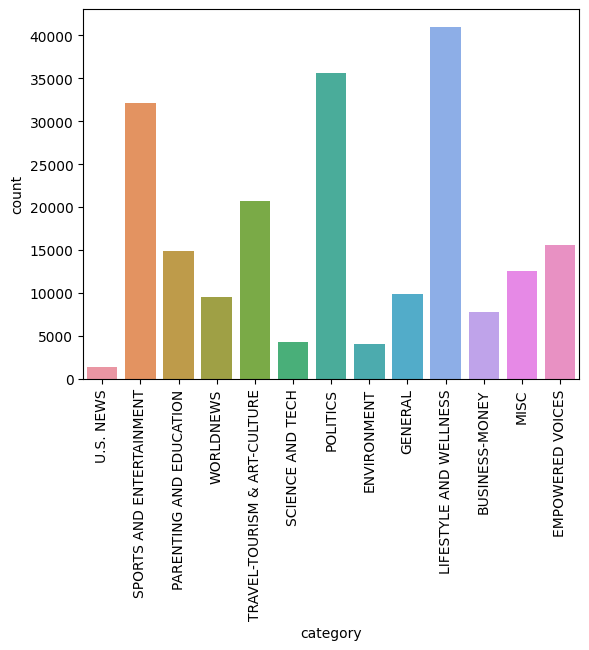

In [49]:
# Count of News belonging to each category
print(df.groupby("category")["headline"].count().sort_values(ascending=False))  # Prints the count of news headlines in each category, sorted in descending order

sns.countplot(x="category", data=df)  # Plots a bar graph showing the count of news in each category
plt.xticks(rotation=90)  # Rotates the x-axis labels by 90 degrees for better readability
plt.show()  # Displays the plot


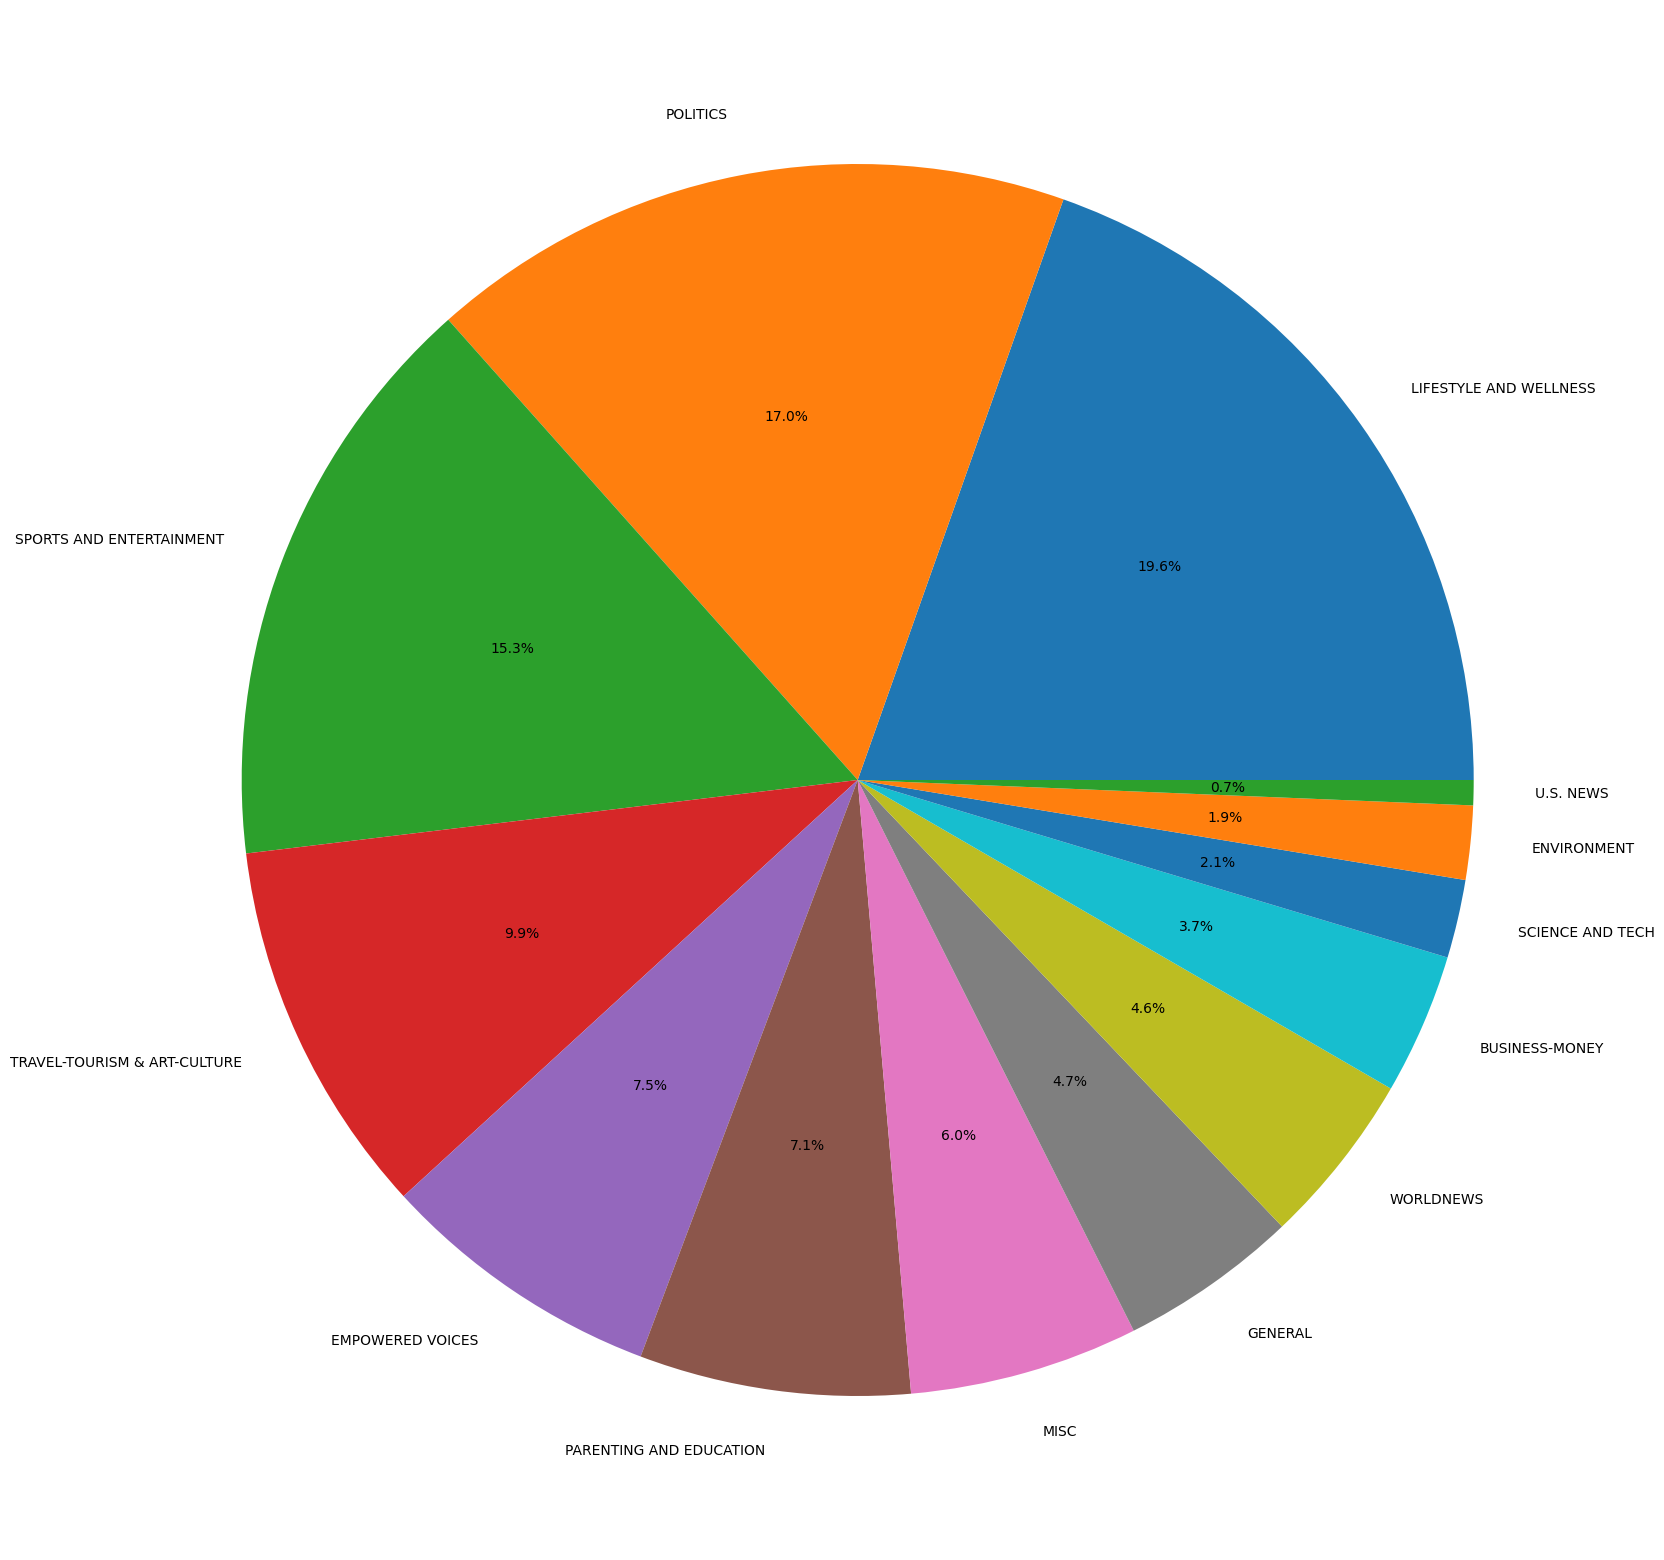

In [50]:
plt.figure(figsize=(20,20))  # Sets the figure size for the pie chart
plt.pie(df["category"].value_counts(), labels=df["category"].value_counts().index, autopct="%1.1f%%", textprops={'fontsize': 10})  # Plots a pie chart showing the percentage of news in each category
plt.show()  # Displays the plot

category
BUSINESS-MONEY                  55.826794
EMPOWERED VOICES                61.505150
ENVIRONMENT                     58.284379
GENERAL                         58.693753
LIFESTYLE AND WELLNESS          54.534604
MISC                            56.622143
PARENTING AND EDUCATION         52.486648
POLITICS                        64.250190
SCIENCE AND TECH                59.501161
SPORTS AND ENTERTAINMENT        62.718630
TRAVEL-TOURISM & ART-CULTURE    50.912574
U.S. NEWS                       68.381990
WORLDNEWS                       61.665269
Name: headline_length, dtype: float64


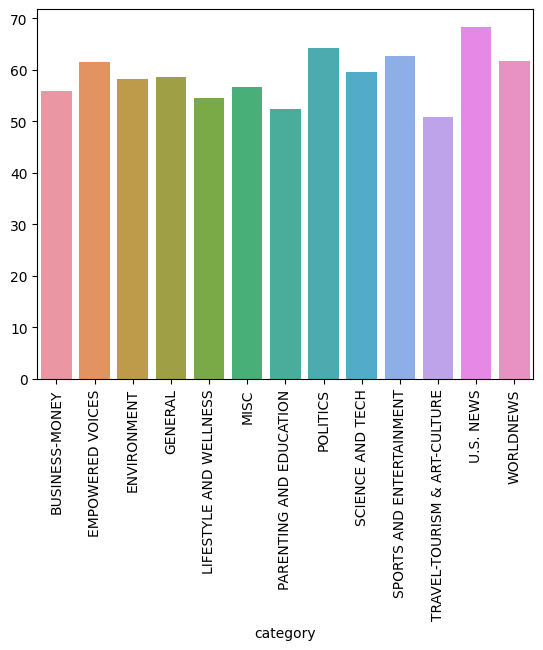

In [51]:
#AVERAGE LENGTH OF TITLE FOR EACH CATEGORY
df["headline_length"] = df["headline"].str.len()
print(df.groupby("category")["headline_length"].mean())
sns.barplot(x=df.groupby("category")["headline_length"].mean().index, y=df.groupby("category")["headline_length"].mean().values)
plt.xticks(rotation=90)
plt.show()

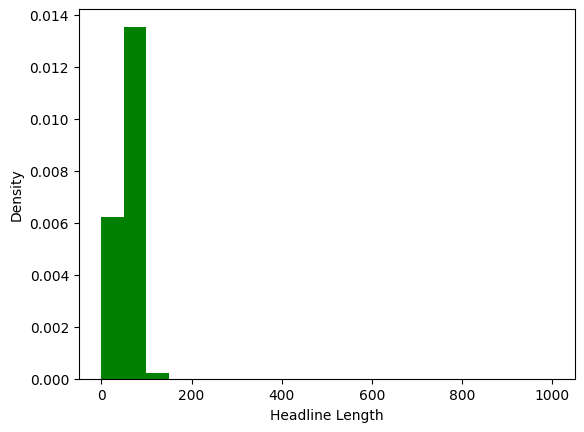

In [52]:
#Density of News vs Paragraph Length
plt.hist(df["headline_length"], bins=20, color="green", range=(0, 1000), density=True)
plt.xlabel("Headline Length")
plt.ylabel("Density")
plt.show()

## Preprocessing of Data

In [53]:
# Combining the 'headline' and 'short_description' columns into a new 'text' column
df['text'] = df['headline'] + ' ' + df['short_description']

In [54]:
# Function to Preprocess Text by Removing Stopwords and Punctuations
def remove_stopwords_and_punctuations(text):
    words = nltk.word_tokenize(text)  # Tokenizes the input text into individual words
    words = [lemmatizer.lemmatize(word) for word in words if word.lower() not in stop_words]  # Lemmatizes the words and removes stopwords
    words_without_punctuations = [''.join(c for c in word if c not in string.punctuation) for word in words]  # Removes punctuation from the words
    words_preprocessed = [word.replace("‘", "").replace("’", "").replace("“"," ").replace("”"," ") for word in words_without_punctuations if len(word)>2]  # Removes certain special characters and words of length 2 or less
    return ' '.join(words_preprocessed)  # Joins the preprocessed words back into a single string

In [ ]:
df['text'] = df['text'].apply(remove_stopwords_and_punctuations)  # Applies the 'remove_stopwords_and_punctuations' function to each entry in the 'text' column of the dataframe

## Tokenizing Text, Counting Top Words by Category, and Generating Word Clouds

In [ ]:
def tokenize_text(text):
    return text.lower().split()  # Splits the input text into individual words (tokens)

df['tokenized_text'] = df['text'].apply(tokenize_text)  # Applies the 'tokenize_text' function to each entry in the 'text' column of the dataframe 'df'

from wordcloud import WordCloud

# Function to count the occurrences of words in each category
def count_top_words_by_category(category_list):
    all_words = [word for words in category_list for word in words]  # Flattens the list of lists into a single list
    word_counts = Counter(all_words)  # Counts the occurrences of each word
    return word_counts.most_common(50)  # Returns the 50 most common words

# Groups the DataFrame by 'category' and applies the count_top_words_by_category function
top_words_by_category = df.groupby('category')['tokenized_text'].apply(count_top_words_by_category).reset_index()

# Creates word maps for each category
for idx, row in top_words_by_category.iterrows():
    category = row['category']  # Current category
    top_words = row['tokenized_text']  # Top words for the current category

    # Creates a dictionary from the top_words list
    word_freq_dict = dict(top_words)

    # Generates a word cloud for the current category
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=50, stopwords=stopwords).generate_from_frequencies(word_freq_dict)

    # Plots the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud for Category: {category}")  # Sets the title of the plot
    plt.axis('off')  # Hides the axis
    plt.show()  # Displays the plot

In [ ]:
# Function to count the occurrences of words in each category
def count_top_words_by_category(category_list):
    all_words = [word for words in category_list for word in words]  # Flattens the list of lists into a single list
    word_counts = Counter(all_words)  # Counts the occurrences of each word
    return word_counts.most_common(10)  # Returns the 10 most common words

# Groups the DataFrame by 'category' and applies the count_top_words_by_category function
top_words_by_category = df.groupby('category')['tokenized_text'].apply(count_top_words_by_category).reset_index()

# Displays the top 10 words for each category
for idx, row in top_words_by_category.iterrows():
    category = row['category']  # Current category
    top_words = row['tokenized_text']  # Top words for the current category
    print(f"Category: {category}")
    print(f"Top 10 words and their count:")
    for word, count in top_words:
        print(f"{word}: {count}")  # Prints each word and its count
    print()  # Prints a newline for readability



In [ ]:
def tokenize_text(text):
    return text.split()  # Splits the input text into individual words (tokens)

df['tokenized_text'] = df['text'].apply(tokenize_text)  # Applies the 'tokenize_text' function to each entry in the 'text' column of the dataframe 'df'

def get_top_ten_words(category):
    # Filters the dataframe by category
    df_category = df[df["category"] == category]
    # Concatenates all the tokens into one list
    all_tokens = []
    for tokens in df_category["tokenized_text"]:
        all_tokens.extend(tokens)
    # Counts the word frequencies using nltk.FreqDist
    freq_dist = nltk.FreqDist(all_tokens)
    # Gets the top ten words and their counts
    top_ten_words = freq_dist.most_common(10)
    return top_ten_words

# Loops through the unique categories and prints the results
for category in df["category"].unique():
    print(f"Top ten common words in {category}:")
    print(get_top_ten_words(category))  # Prints the top ten common words in the current category


# Encoding Category Labels and Creating a Mapping Dictionary

In [ ]:
encoder = LabelEncoder()  # Initializes a LabelEncoder object
df['categoryEncoded'] = encoder.fit_transform(df['category'])  # Encodes the 'category' column and stores the result in a new 'categoryEncoded' column
category_dict = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))  # Creates a dictionary mapping the original category names to their encoded values

# Prints the dictionary
print(category_dict)  # Prints the mapping of category names to their encoded values

In [ ]:
def regular_encode(texts, tokenizer, maxlen=512):
    enc_di = tokenizer.batch_encode_plus(
        texts,
        return_token_type_ids=False,
        pad_to_max_length=True,
        max_length=maxlen
    )  # Encodes a batch of texts using the provided tokenizer, padding all texts to a specified maximum length
    return np.array(enc_di['input_ids'])  # Returns the encoded texts as a numpy array

# Splitting Data into Train,Test,Validation Dataset

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(df['text'], df['categoryEncoded'], random_state = 2020, test_size = 0.3)  # Splits the data into a training set and a temporary set (for validation and testing) with a 70-30 split
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, random_state = 2020, test_size = 0.5)  # Splits the temporary set into validation and testing sets with a 50-50 split

#70 15 15

# DistilBERT

## Tokenization

In [ ]:
# Tokenization
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# Initializes a DistilBert tokenizer with a pre-trained model
# The tokenizer returns dictionaries of input ids, attention masks, and token type ids for each text

In [ ]:
"""
The tokenizer function is a tool that converts text into numerical representations that can be fed into a machine learning model.
It usually performs tasks such as splitting the text into tokens, mapping the tokens to unique ids, and adding special tokens such as [CLS] and [SEP].
[CLS] token stands for “classification” [SEP] token stands for “separation”
"""

Xtrain_encoded = regular_encode(X_train.astype('str'), tokenizer, maxlen=512)
# Encodes the training data using the 'regular_encode' function and the tokenizer
Xval_encoded = regular_encode(X_val.astype('str'), tokenizer, maxlen=512)
# Encodes the validation data using the 'regular_encode' function and the tokenizer
Xtest_encoded = regular_encode(X_test.astype('str'), tokenizer, maxlen=512)
# Encodes the testing data using the 'regular_encode' function and the tokenizer

In [ ]:
ytrain_encoded = tf.keras.utils.to_categorical(y_train, num_classes=27, dtype='int32')
# Converts the training labels to a binary matrix representation (one-hot encoding)
yval_encoded = tf.keras.utils.to_categorical(y_val, num_classes=27, dtype='int32')
# Converts the validation labels to a binary matrix representation (one-hot encoding)
ytest_encoded = tf.keras.utils.to_categorical(y_test, num_classes=27, dtype='int32')
# Converts the testing labels to a binary matrix representation (one-hot encoding)

# Building the Model with Transformer Layer and Compiling it

In [ ]:
def build_model(transformer, loss='categorical_crossentropy', max_len=512):
    input_word_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")  # Input layer for the model
    sequence_output = transformer(input_word_ids)[0]  # Transformer layer that processes the input
    cls_token = sequence_output[:, 0, :]  # Extracts the [CLS] token's outputs for classification
    x = tf.keras.layers.Dropout(0.5)(cls_token)  # Dropout layer to prevent overfitting
    x = tf.keras.layers.Dense(128, activation='relu')(x)  # Dense layer with ReLU activation function
    out = tf.keras.layers.Dense(27, activation='softmax')(x)  # Output layer with softmax activation function for multi-class classification
    model = tf.keras.Model(inputs=input_word_ids, outputs=out)  # Builds the model
    optimizer = transformers.AdamWeightDecay(learning_rate=2e-5, weight_decay_rate=0.01)  # Optimizer with weight decay for regularization
    f1_score = tfa.metrics.F1Score(num_classes=27, average='macro')  # F1 score metric for multi-class classification
    model.compile(optimizer, loss=loss, metrics=[f1_score])  # Compiles the model with the specified optimizer, loss function, and metrics
    return model  # Returns the model

In [ ]:
with strategy.scope():
    transformer_layer = transformers.TFAutoModel.from_pretrained('distilbert-base-uncased')  # Loads the pre-trained DistilBERT model
    model = build_model(transformer_layer, max_len=512)  # Builds the model using the build_model function and the transformer layer
model.summary()  # Prints a summary of the model

# Creating TensorFlow Datasets for Training, Validation, and Testing

In [ ]:
BATCH_SIZE = 32*strategy.num_replicas_in_sync  # Sets the batch size based on the number of replicas in the strategy
#BATCH_SIZE = 6  # Choose an appropriate batch size for GPU training
AUTO = tf.data.experimental.AUTOTUNE  # Constant that represents automatic tuning of performance-related options
# This constant is used to indicate that the decision for the optimal amount of resources (like the number of threads, buffer sizes etc.) to allocate for loading and preprocessing data should be left to TensorFlow.
# It dynamically adjusts these based on the system's available resources, thus improving efficiency.

train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((Xtrain_encoded, ytrain_encoded))  # Creates a dataset from the training data and labels
    .repeat()  # Repeats the dataset indefinitely
    .shuffle(2048)  # Shuffles the dataset
    .batch(BATCH_SIZE)  # Batches the dataset
    .prefetch(AUTO)  # Prefetches elements from the dataset to improve performance
)

val_dataset = (
    tf.data.Dataset
    .from_tensor_slices((Xval_encoded, yval_encoded))  # Creates a dataset from the validation data and labels
    .batch(BATCH_SIZE)  # Batches the dataset
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(Xtest_encoded)  # Creates a dataset from the testing data
    .batch(BATCH_SIZE)  # Batches the dataset
)

"""
The tf.data.Dataset.from_tensor_slices method is a way to create a TensorFlow dataset from an array or a list of tensors.
It slices the input tensors along the first dimension and returns a dataset of tensor slices.
Each slice has the same shape as the original tensor, except for the first dimension, which is reduced by one.
For example, if you have a tensor of shape (3, 2), the method will return a dataset of three slices, each of shape (2,).
You can use this method to create datasets from in-memory data that fit in memory, such as images and labels. You can also use this method to create datasets from other datasets by applying transformations.
"""

In [ ]:
n_steps = Xtrain_encoded.shape[0] // BATCH_SIZE  # Calculates the number of steps per epoch for the training data

In [ ]:
# Use early stopping and model checkpointing
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)  # Early stopping callback to stop training when the model stops improving
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('./drive/MyDrive/best_model.h5', save_best_only=True)  # Model checkpoint callback to save the best model during training

"""
EarlyStopping is a callback provided by Keras that can be used to stop the training process if the model's performance has stopped improving on a validation dataset.
In this case, 'patience=2' means that we will stop training if there is no improvement in the model's validation loss for 2 consecutive epochs.
'restore_best_weights=True' means that the model weights from the epoch with the best monitored metric (in this case, validation loss) will be restored.

ModelCheckpoint is another callback provided by Keras that can be used to save the model at different points during training.
It can be configured to save the model after every epoch, only when the model improves, or at specific intervals.
In this case, 'save_best_only=True' means that the latest best model according to the monitored metric (in this case, validation loss) will not be overwritten.
The advantage of using this callback is that you can resume training from the saved models, which can be very helpful if a long-running training process is interrupted.

The advantage of using these callbacks is that they can save computational resources by stopping the training process early if the model is no longer improving,
and they can ensure that the best model found during the training process is saved and can be reused later.
"""

In [ ]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)  # Learning rate scheduler callback to reduce the learning rate when the validation loss stops improving

"""
The ReduceLROnPlateau callback is a way to reduce the learning rate when the model's performance stops improving.
It monitors a specified metric (in this case, 'val_loss'), and if no improvement is seen for a 'patience' number of epochs,
the learning rate is reduced by a factor (in this case, 0.2).
The learning rate will never be reduced below 'min_lr' (in this case, 1e-6).
This is useful in scenarios where the learning rate might be too high to allow the model to converge,
and reducing it can help the model to continue improving.
"""

In [ ]:
train_history = model.fit(
    train_dataset,  # Training data
    steps_per_epoch=n_steps,  # Number of steps per epoch
    validation_data=val_dataset,  # Validation data
    epochs=30,  # Number of epochs to train for
    callbacks=[early_stopping, model_checkpoint, lr_scheduler]  # List of callbacks to apply during training
)  # Trains the model for a specified number of epochs and returns a History object

# Loading the Best Model, Making Predictions on the Test Set, and Calculating Evaluation Metrics

In [ ]:
from transformers import TFDistilBertModel, AdamWeightDecay
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import custom_object_scope

with custom_object_scope({'TFDistilBertModel': TFDistilBertModel, 'AdamWeightDecay': AdamWeightDecay}):
    model = load_model('./drive/MyDrive/best_model.h5')  # Loads the best model saved during training

# Predicts on the test set
preds = model.predict(test_dataset, verbose=1)
pred_classes = np.argmax(preds, axis=1)  # Gets the class with the highest predicted probability for each example

# Calculates the metrics
print(f"Accuracy: {sklearn.metrics.accuracy_score(y_test, pred_classes)}")  # Prints the accuracy of the model
print(f"Precision: {sklearn.metrics.precision_score(y_test, pred_classes, average='macro')}")  # Prints the macro-averaged precision of the model
print(f"Recall: {sklearn.metrics.recall_score(y_test, pred_classes, average='macro')}")  # Prints the macro-averaged recall of the model
print(f"F1-score: {sklearn.metrics.f1_score(y_test, pred_classes, average='macro')}")  # Prints the macro-averaged F1 score of the model


# Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(y_test, pred_classes)

# Display the confusion matrix
plt.figure(figsize=(10, 10))  # Sets the figure size
sns.heatmap(cm, annot=True, fmt="d")  # Plots the confusion matrix as a heatmap
plt.title('Confusion matrix')  # Sets the title of the plot
plt.ylabel('Actual label')  # Sets the label of the y-axis
plt.xlabel('Predicted label')  # Sets the label of the x-axis
plt.show()  # Displays the plot

In [ ]:
# Plotting the training and validation loss
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()  # Displays the plot

In [ ]:
# Subtract the diagonal elements from the row sums to get the number of incorrect predictions for each class
incorrect_predictions = cm.sum(axis=1) - np.diag(cm)

# Find the class with the most incorrect predictions
most_incorrect_class = np.argmax(incorrect_predictions)

print(f"The category that was predicted most incorrectly is: {encoder.inverse_transform([most_incorrect_class])[0]}")

In [ ]:
print(f"Accuracy: {sklearn.metrics.accuracy_score(y_test, pred_classes)}")  # Prints the accuracy of the model on the test data
print(f"Precision: {sklearn.metrics.precision_score(y_test, pred_classes, average='micro')}")  # Prints the micro-averaged precision of the model on the test data
print(f"Recall: {sklearn.metrics.recall_score(y_test, pred_classes, average='micro')}")  # Prints the micro-averaged recall of the model on the test data
print(f"F1-score: {sklearn.metrics.f1_score(y_test, pred_classes, average='micro')}")  # Prints the micro-averaged F1 score of the model on the test data

In [ ]:
print(f"Accuracy: {sklearn.metrics.accuracy_score(y_test, pred_classes)}")  # Prints the accuracy of the model on the test data
print(f"Precision: {sklearn.metrics.precision_score(y_test, pred_classes, average='weighted')}")  # Prints the weighted precision of the model on the test data
print(f"Recall: {sklearn.metrics.recall_score(y_test, pred_classes, average='weighted')}")  # Prints the weighted recall of the model on the test data
print(f"F1-score: {sklearn.metrics.f1_score(y_test, pred_classes, average='weighted')}")  # Prints the weighted F1 score of the model on the test data

# convert h5 model format to tflite

In [ ]:
import tensorflow as tf
from transformers import TFDistilBertModel  # Replace with your actual custom layer
from transformers import optimization_tf as optimization  # Import the custom optimizer

# Register the custom layer and optimizer before loading the model
tf.keras.utils.get_custom_objects()["TFDistilBertModel"] = TFDistilBertModel
tf.keras.utils.get_custom_objects()["AdamWeightDecay"] = optimization.AdamWeightDecay

# Load the saved model in HDF5 format
model = tf.keras.models.load_model('./drive/MyDrive/best_model.h5')

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open('converted_model.tflite', 'wb') as file:
    file.write(tflite_model)
